In [1]:
#!/usr/bin/env python3.7
#coding:utf-8

# Heavily borrows from https://github.com/Priesemann-Group/covid19_inference

import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime
# import theano
# import theano.tensor as tt
import pymc3 as pm

import pickle
import datetime

import matplotlib.pyplot as plt




In [2]:
trace = pickle.load(open("traces/trace_hospital_working.dat","rb"))

print(trace)

<MultiTrace: 2 chains, 300 iterations, 26 variables>


77 77 76 77


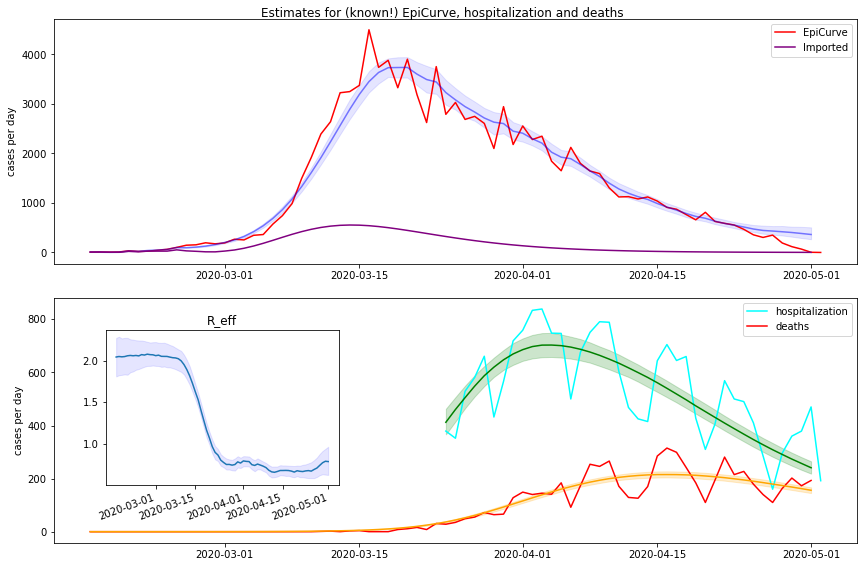

In [3]:
epi_curve = [7, 10, 8, 10, 34, 22, 26, 46, 64, 103, 147, 155, 196, 175, 193, 268, 254, 347, 363, 573, 745, 988, 1497, 1920, 2393, 2641, 3227, 3250, 3376, 4499, 3740, 3882, 3328, 3905, 3187, 2625, 3755, 2791, 3031, 2688, 2750, 2608, 2101, 2946, 2181, 2556, 2282, 2349, 1844, 1651, 2123, 1800, 1646, 1594, 1305, 1122, 1128, 1081, 1122, 1039, 911, 874, 766, 660, 812, 627, 589, 555, 468, 357, 304, 351, 192, 118, 68, 4, 1]
#epi_curve = [0]*4+epi_curve
epi_curve = ma.masked_less(epi_curve,0.,copy=True)

initial_obs_rki_sit = [9.188,9.188,4.594,4.594,22.971,13.783,27.565,27.565,27.565,53.507,32.821]+[x*.8 for x in [30,17,16,36]+[63.072,106.910,163.956,231.851,306.731,383.947,458.793,527.101,585.620,632.178,665.686,686.005,693.759,690.122,676.616,654.935,626.805,593.878,557.666,519.498,480.503,441.606,403.541,366.868,331.992,299.187,268.619,240.364,214.431,190.776,169.313,149.934,132.509,116.901,102.965,90.561,79.549,69.796,61.177,53.573,46.877,40.989,35.819,31.284,27.311,23.833,20.792,18.134,15.812,13.785,12.017,10.475,9.130,7.958,6.937,6.047,5.272,4.596,4.008,3.496,3.049]]#,2.661,2.322]#,2.027,1.770]
imported_cases = np.asarray(initial_obs_rki_sit[:len(epi_curve)],dtype=np.float64)
hospital = [-1]*17+[-1]*20+[379,352,529,581,661,432,566,719,759,834,839,748,747,500,676,751,791,789,604,468,425,415,644,705,645,660,428,310,405,569,500,490,410,286,160,296,360,379,470,192] 
hospital = ma.masked_less(hospital,0.,copy=True)

deaths = [0]*17+[0,0,0,0,0,0,0,1,2,0,3,4,0,0,0,8,11,16,8,31,28,35,49,55,72,64,66,128,149,140,145,141,184,92,173,254,246,266,171,129,126,170,285,315,299,242,184,110,194,281,215,227,179,140,110,163,202,173,193]
#deaths = [0]*4+deaths
deaths = np.asarray(deaths,dtype=np.float64)

icu_deaths = [-1]*17+[-1]*36+[93,154,0,131,88,66,228,255,305,123,50,59,108,91,115,39,22,29,24,68,69,52,40,46]
icu_deaths_begin = 17+30
icu_deaths = ma.masked_less(icu_deaths,0.,copy=True)

print(len(epi_curve),len(hospital),len(deaths),len(icu_deaths))

time_arr=pd.date_range(datetime.date(2020,2,16), periods=trace.lambda_t_random_walk.shape[1], freq='D')
time_arrL=pd.date_range(datetime.date(2020,2,16), periods=trace.lambda_t_random_walk.shape[1]+10, freq='D')
dtx = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15),datetime.date(2020,5,1)]

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
fig.suptitle('Estimates for (known!) EpiCurve, hospitalization and deaths')
ax = axes[0,0]
bx = axes[1,0]
cx = fig.add_axes([.11,.15,.27,.27])

ax.plot(time_arrL[:len(epi_curve)],epi_curve,color="red",label="EpiCurve")
ax.plot(time_arr,np.median(trace.infected_t,axis=0),color="blue",alpha=.5)
ax.fill_between(time_arr,*np.percentile(trace.infected_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
ax.plot(time_arrL[:len(initial_obs_rki_sit)],initial_obs_rki_sit,c="purple",label="Imported")
#ax.plot(trace.scaled_imported_cases,axis=0)
ax.set_ylabel("cases per day")
ax.legend(loc=1)
ax.set_xticks(dtx)
ax.set_xticklabels(dtx)

bx.plot(time_arrL[:len(hospital)],hospital,color="cyan",label="hospitalization")
bx.plot(time_arr[37:],np.median(trace.hosp_t,axis=0),color="green")
bx.fill_between(time_arr[37:],*np.percentile(trace.hosp_t, axis=0, q=(12.5,87.5)),color="green",alpha=.2)

bx.plot(time_arr[:len(deaths)],deaths,color="red",label="deaths")
bx.plot(time_arr,np.median(trace.dead_t,axis=0),color="orange")
bx.fill_between(time_arr,*np.percentile(trace.dead_t, axis=0, q=(12.5,87.5)),color="orange",alpha=.2)

if False:
    bx.plot(time_arrL[:len(icu_deaths)],icu_deaths,color="black",label="ICU_deaths")
    bx.plot(time_arr[icu_deaths_begin:],np.median(trace.ICU_dead_t,axis=0),color="grey")
    bx.fill_between(time_arr[icu_deaths_begin:],*np.percentile(trace.ICU_dead_t, axis=0, q=(12.5,87.5)),color="grey",alpha=.2)

bx.set_ylabel("cases per day")
bx.legend(loc=1)
bx.set_xticks(dtx)
bx.set_xticklabels(dtx)


cx.set_title("R_eff")
cx.plot(time_arr,np.median(trace.lambda_t,axis=0))
cx.fill_between(time_arr,*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
cx.set_xticks(dtx)
cx.set_xticklabels(dtx,rotation=20,horizontalalignment='right')

plt.savefig("EstEpiCurve.pdf")

In [4]:
print(np.mean(trace.lambda_0))
print(np.mean(trace.f_death))
print(np.mean(trace.m_death))
#print(np.mean(trace.s_death))
#print(np.mean(trace.median_imported_factor))
print("incubation",np.mean(trace.median_incubation))
print(np.mean(trace.f_hospital))
print(np.mean(trace.m_hospital))
#print(np.mean(trace.s_hospital))

2.044443409079633
0.08371545935751527
24.808831270945813
incubation 3.7328335280049383
0.23685377551440032
13.729666672693456


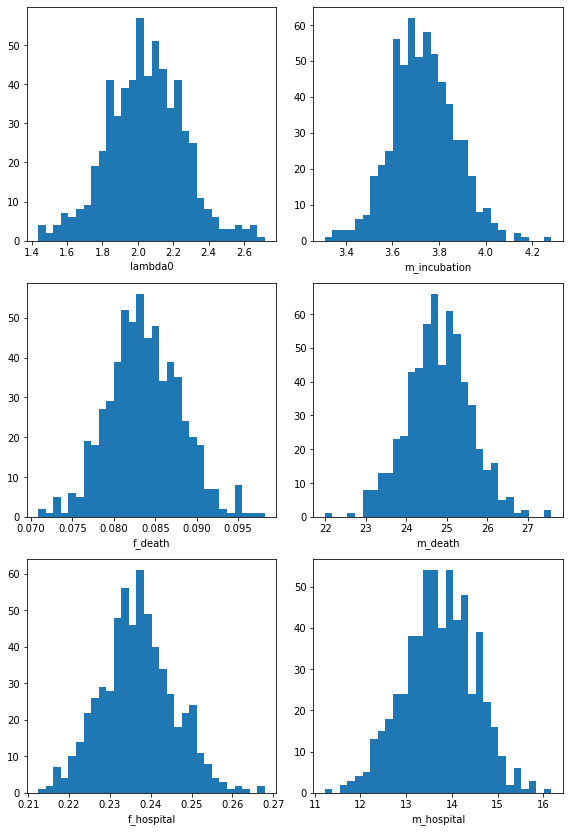

In [6]:
#plt.hist(trace.lambda_0)
t = trace
dh = {"lambda0":t.lambda_0,"m_incubation":t.median_incubation,"f_death":t.f_death,"m_death":t.m_death}
dh.update({"f_hospital":t.f_hospital,"m_hospital":t.m_hospital})
#dh.update({"f_ICU_death":t.f_ICU_death,"m_ICU_death":t.m_ICU_death})
hy = int(np.ceil(len(dh)/2.))
fig, axes = plt.subplots(hy,2 , figsize = (8,4*hy),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)

for i,k in enumerate(dh.keys()):
    d = dh[k]
    ax = axes[i//2,i%2]
    ax.hist(d,bins=30)
    ax.set_xlabel(k)

#plt.hist(trace.f_hospital,bins=30)